This notebook aims to provide a quantification of the Actions (and their releases) from the dataset, as well as some insights about the release frequency of Actions and the evolution of this frequency through time. It also provides insight on how frequently workflows are updated in repositories using GHA.

In [45]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot
import seaborn
import lifelines

In [46]:
FIG_SIZE = (7, 3)

PALETTE = seaborn.color_palette()
DATE_RANGE = pd.to_datetime('2019-11-01'), pd.to_datetime('2022-09-30')
REL_CENSOR = pd.to_datetime('2018-10-16')  # Limited public beta of GHA

matplotlib.rcParams['figure.figsize'] = FIG_SIZE
# matplotlib.rcParams['legend.framealpha'] = 1
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

SEED = 12345
SAVEFIG = True

def _savefig(fig, name):
    import os
    fig.savefig(
        os.path.join('..', 'figures', '{}.pdf'.format(name)),
        bbox_inches='tight'
    )
    
savefig = _savefig if SAVEFIG else lambda x, y: None

### Load data

In [47]:
# Releases of Actions
df_releases = (
    pd.read_csv('../data/releases.csv.gz')
    .assign(date=lambda d: pd.to_datetime(d.date, errors='coerce').dt.tz_convert(None))
    .rename(columns={'release': 'version'})
    [lambda d: d.date.between(REL_CENSOR, pd.to_datetime('2022-08-31'), inclusive='both')]
    [['owner', 'repo', 'version', 'date']]
)

In [4]:
# Updates of workflows
df_workflows = (
    pd.read_csv('../data/workflow_files.csv.gz')
    .assign(date=lambda d: pd.to_datetime(d.date))
    [['repository', 'date', 'filename', 'workflow']]
)

### Data overview

In [5]:
print('There are', len(df_releases), 'releases')
print('There are', len(df_releases.drop_duplicates(['owner', 'repo'])), 'distinct actions')

There are 28889 releases
There are 2811 distinct actions


#### Evolution of the number of Actions and releases

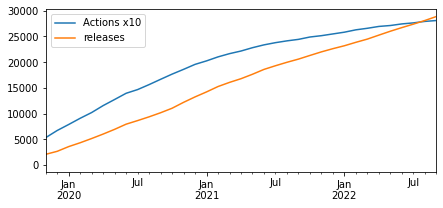

In [6]:
fig, ax = matplotlib.pyplot.subplots()

temp = (
    df_releases
    .sort_values('date', ascending=True)
    .drop_duplicates(['owner', 'repo'], keep='first')
    .assign(actions=lambda d: range(1, len(d) + 1))
    .merge(
        df_releases.sort_values('date', ascending=True).assign(releases=lambda d: range(1, len(d) + 1)),
        how='right',
        on=['owner', 'repo', 'date'],
    )
    [['date', 'owner', 'repo', 'actions', 'releases']]
    .fillna(method='ffill')
    .assign(date=lambda d: d.date + pd.offsets.DateOffset(months=1))
    .groupby(pd.Grouper(key='date', freq='M'))
    .max()
)

(
    temp
    [['actions', 'releases']]
    .assign(actions=lambda d: d.actions * 10)
    .rename(columns={'actions': 'Actions x10'})
    .plot(ax=ax, color=PALETTE)
)

ax.set(
    xlabel=None,
    xlim=DATE_RANGE,
    ylabel=None
)

savefig(fig, 'rel_evolution')

In [7]:
display(temp[lambda d: d.index >= DATE_RANGE[0]].iloc[0])
display(temp.iloc[-1])

owner            yockow
repo        zip-release
actions           530.0
releases           2051
Name: 2019-11-30 00:00:00, dtype: object

owner              zricethezav
repo        zola-deploy-action
actions                 2811.0
releases                 28889
Name: 2022-09-30 00:00:00, dtype: object

#### Monthly number of releases

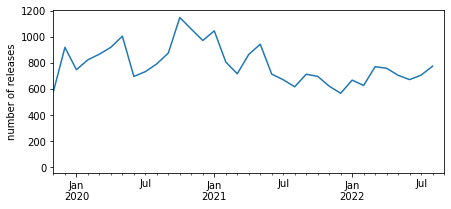

In [8]:
fig, ax = matplotlib.pyplot.subplots()

temp = (
    df_releases
    .groupby(pd.Grouper(key='date', freq='M'))
    .agg(releases=('version', 'count'))
)

temp['releases'].plot(ax=ax, color=PALETTE)

ax.set(
    xlabel=None,
    xlim=DATE_RANGE,
    ylabel='number of releases',
)

savefig(fig, 'rel_monthly_number')

In [9]:
temp.describe()

,releases
count,47.000000
mean,614.659574
std,327.628188
min,12.000000
25%,567.500000
50%,706.000000
75%,816.500000
max,1149.000000


#### Monthly proportion of Actions being updated

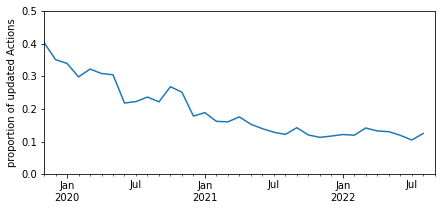

In [10]:
fig, ax = matplotlib.pyplot.subplots()

temp = (
    df_releases
    .sort_values('date', ascending=True)
    .drop_duplicates(['owner', 'repo'], keep='first')
    .assign(actions=lambda d: range(1, len(d) + 1))
    .groupby(pd.Grouper(key='date', freq='M'))
    .agg({'actions': 'max'})
    .merge(
        df_releases
        .assign(repository=lambda d: d.owner + '/' + d.repo)
        .groupby(pd.Grouper(key='date', freq='M'))
        .agg(updated=('repository', 'nunique')),
        how='outer',
        left_index=True,
        right_index=True,
    )
    .loc[DATE_RANGE[0]:DATE_RANGE[1]]
    .assign(proportion=lambda d: d['updated'] / d['actions'])
)

temp['proportion'].plot(ax=ax, color=PALETTE)

ax.set(
    xlabel=None,
    xlim=DATE_RANGE,
    ylim=(0, 0.5), 
    ylabel='proportion of updated Actions'
)

savefig(fig, 'rel_prop_updated')

In [11]:
display(temp.describe().T)
display(temp.iloc[-1])

,count,mean,std,min,25%,50%,75%,max
actions,34.0,2053.088235,646.182419,669.000000,1588.750000,2249.500000,2575.500000,2811.000000
updated,34.0,350.529412,53.766744,270.000000,308.750000,351.000000,379.500000,499.000000
proportion,34.0,0.195418,0.083917,0.104868,0.125845,0.161314,0.247678,0.403587


actions       2811.000000
updated        351.000000
proportion       0.124867
Name: 2022-08-31 00:00:00, dtype: float64

#### Evolution of the number of workflow updates

A workflow update is detected by comparing the hash value of a workflow file with the hash value for the same workflow file in the previous snapshot. Newly introduced workflows are also considered as updates. 

In [12]:
# Let's store this dataframe since it will be used in many of the following cells.
data = (
    df_workflows
    .sort_values(['repository', 'filename', 'date'])
    .assign(workflow_previous=lambda d: d.workflow.shift(1))
    # Since we applied shift on all repositories/date, let's remove the extra ones. 
    .assign(workflow_previous=lambda d: d.workflow_previous.where(d[['repository', 'filename']].duplicated(), np.nan))
    .assign(updated=lambda d: d.workflow != d.workflow_previous)
)

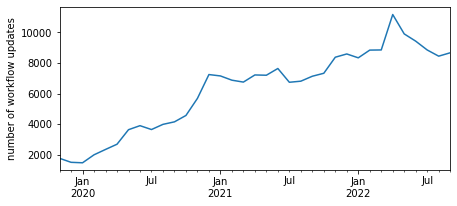

In [13]:
fig, ax = matplotlib.pyplot.subplots()

temp = (
    data
    .groupby(pd.Grouper(key='date', freq='M'))
    .agg(updates=('updated', 'sum'))
)

temp['updates'].plot(ax=ax, color=PALETTE)

ax.set(
    xlabel=None,
    xlim=DATE_RANGE,
    ylabel='number of workflow updates',
)

savefig(fig, 'rel_workflow_monthly_updates')

Proportions: 

In [14]:
_ = (
    data
    .groupby(pd.Grouper(key='date', freq='M'))
    .agg(
        updated=('updated', 'sum'),
        workflows=('workflow', 'count'),
    )
    .assign(workflows=lambda d: d.updated / d.workflows)
    [['workflows']]
    .iloc[1:]
)

display(_.describe().T)
display(_.iloc[-1])

,count,mean,std,min,25%,50%,75%,max
workflows,34.0,0.270937,0.096164,0.159713,0.193406,0.240967,0.308445,0.552881


workflows    0.161187
Name: 2022-09-30 00:00:00, dtype: float64

#### Monthly proportion of repositories updating a workflow file

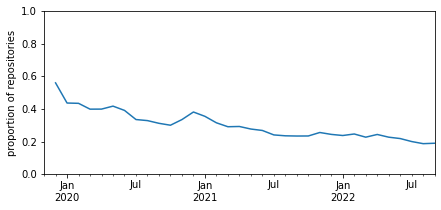

In [15]:
fig, ax = matplotlib.pyplot.subplots()

temp = (
    data
    .sort_values(['date', 'repository'])
    .assign(repositories=lambda d: (~d['repository'].duplicated()).cumsum())
    [lambda d: d.updated]
    .groupby(pd.Grouper(key='date', freq='M'))
    .agg(
        updated=('repository', 'nunique'),
        repositories=('repositories', 'max'),
    )
    .assign(proportion=lambda d: d.updated / d.repositories)
)

temp['proportion'].iloc[1:].plot(ax=ax, color=PALETTE)

ax.set(
    xlabel=None,
    xlim=DATE_RANGE,
    ylabel='proportion of repositories',
    ylim=(0, 1)
)

savefig(fig, 'rel_workflow_prop_repo_updated')

In [16]:
display(temp.describe().T)
display(temp.iloc[-1])

,count,mean,std,min,25%,50%,75%,max
updated,35.0,3529.342857,1308.687329,1055.000000,2441.500000,4150.000000,4386.500000,5167.0
repositories,35.0,13327.171429,7044.768983,1237.000000,7199.500000,14644.000000,19603.000000,22758.0
proportion,35.0,0.321458,0.145351,0.187231,0.236345,0.291065,0.368136,1.0


updated          4320.000000
repositories    22758.000000
proportion          0.189823
Name: 2022-09-30 00:00:00, dtype: float64

#### Combining monthly proportion of updated actions/updated repositories

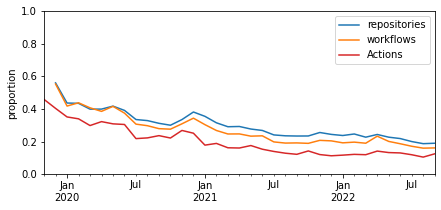

In [17]:
fig, ax = matplotlib.pyplot.subplots()


# Code taken from the above cell
(
    data
    .sort_values(['date', 'repository'])
    .assign(repositories=lambda d: (~d['repository'].duplicated()).cumsum())
    [lambda d: d.updated]
    .groupby(pd.Grouper(key='date', freq='M'))
    .agg(
        updated=('repository', 'nunique'),
        repositories=('repositories', 'max'),
    )
    .assign(repositories=lambda d: d.updated / d.repositories)
    [['repositories']]
    .iloc[1:]
    .plot(ax=ax, color=PALETTE[0])
)

(
    data
    .groupby(pd.Grouper(key='date', freq='M'))
    .agg(
        updated=('updated', 'sum'),
        workflows=('workflow', 'count'),
    )
    .assign(workflows=lambda d: d.updated / d.workflows)
    [['workflows']]
    .iloc[1:]
    .plot(ax=ax, color=PALETTE[1])
)

# Code taken from a cell above
(
    df_releases
    .sort_values('date', ascending=True)
    .assign(date=lambda d: d.date + pd.offsets.DateOffset(months=1))
    .drop_duplicates(['owner', 'repo'], keep='first')
    .assign(actions=lambda d: range(1, len(d) + 1))
    .groupby(pd.Grouper(key='date', freq='M'))
    .agg({'actions': 'max'})
    .merge(
        df_releases
        .assign(date=lambda d: d.date + pd.offsets.DateOffset(months=1))
        .assign(repository=lambda d: d.owner + '/' + d.repo)
        .groupby(pd.Grouper(key='date', freq='M'))
        .agg(updated=('repository', 'nunique')),
        how='outer',
        left_index=True,
        right_index=True,
    )
    .assign(actions=lambda d: d['updated'] / d['actions'])
    .loc[DATE_RANGE[0]:DATE_RANGE[1]]
    [['actions']]
    .rename(columns={'actions': 'Actions'})
    .plot(ax=ax, color=PALETTE[3])
)

ax.set(
    xlabel=None,
    xlim=DATE_RANGE,
    ylim=(0, 1), 
    ylabel='proportion'
)

savefig(fig, 'rel_prop_updated_both')

### Time to update a workflow file

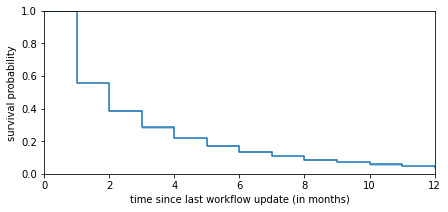

In [18]:
fig, ax = matplotlib.pyplot.subplots()

kmf = lifelines.KaplanMeierFitter()

temp = (
    data
    [lambda d: d.updated]
    .sort_values(['repository', 'filename', 'date'])
    .assign(previous_date=lambda d: d.date.shift(1))
    # Since we applied shift on all repositories/date, let's remove the extra ones. 
    .assign(previous_date=lambda d: d.previous_date.where(d[['repository', 'filename']].duplicated(), np.nan))
    .assign(duration=lambda d: ((d.date - d.previous_date).dt.days / 30).round())
    [lambda d: ~d.duration.isnull()]
)

kmf.fit(temp.duration)
kmf.plot(legend=False, color=PALETTE[0], ax=ax)

ax.set(
    xlabel='time since last workflow update (in months)', 
    xlim=(0, 12),
    ylabel='survival probability',
    ylim=(0, 1),
)

savefig(fig, 'rel_survival_workflows')

### Release frequency

#### Distribution of the number of releases

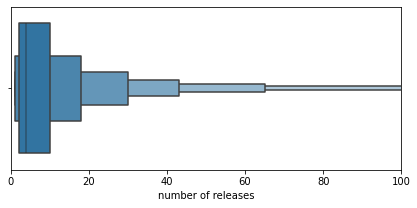

In [19]:
fig, ax = matplotlib.pyplot.subplots()

temp = (
    df_releases
    .groupby(['owner', 'repo'], as_index=False)
    .agg(releases=('version', 'count'))   
)

seaborn.boxenplot(
    data=temp,
    orient='h',
    palette=PALETTE,
    ax=ax,
)

ax.set_yticklabels([])

ax.set(
    xlabel='number of releases',
    xlim=(0, 100),
    ylabel=None,
)
       
savefig(fig, 'rel_distribution_number')

In [20]:
temp.releases.describe()

count    2811.000000
mean       10.277126
std        31.201441
min         1.000000
25%         2.000000
50%         4.000000
75%        10.000000
max      1074.000000
Name: releases, dtype: float64

#### Same analysis, but different visualization

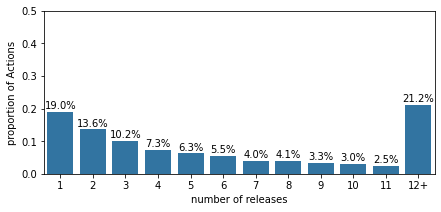

In [44]:
fig, ax = matplotlib.pyplot.subplots()

threshold = 12

temp = (
    df_releases
    .groupby(['owner', 'repo'], as_index=False)
    .agg(releases=('version', 'count'))
    .assign(releases=lambda d: np.where(d.releases < threshold, d.releases, f'{threshold}+'))
    .groupby('releases', as_index=False)
    .agg(actions=('repo', 'count'))
    .assign(prop=lambda d: d.actions / d.actions.sum())
)
        
seaborn.barplot(
    x='releases',
    y='prop',
    order=list(map(str, range(1, threshold))) + [f'{threshold}+'],
    data=temp,
    color=PALETTE[0],
    ax=ax,
)

for row in temp.itertuples():
    try:
        x = int(row.releases)
    except ValueError:
        x = int(row.releases[:-1])
        
    ax.text(x - 1, row.prop + 0.01, '{:.1%}'.format(row.prop), ha='center')

ax.set(
    xlabel='number of releases',
    ylabel='proportion of Actions',
    ylim=(0, 0.50),
)
       
savefig(fig, 'rel_distribution_number_variant')

In [22]:
temp.set_index('releases').loc[list(map(str, range(1, threshold))) + [f'{threshold}+']].T.round(3)

releases,1,2,3,4,5,6,7,8,9,10,11,12+
actions,535.00,382.000,286.000,205.000,176.000,156.000,112.00,114.000,94.000,84.00,70.000,597.000
prop,0.19,0.136,0.102,0.073,0.063,0.055,0.04,0.041,0.033,0.03,0.025,0.212


#### Distribution of the time since last update

In [23]:
# Let's store this dataframe since it will be used in many cells.
data = (
    df_releases
    .sort_values(['owner', 'repo', 'date'])
    .assign(updated=lambda d: d.date.shift(-1))
    # Since we applied shift on all actions/date, let's remove the extra ones. 
    .assign(updated=lambda d: d.updated.where(d[['owner', 'repo']].duplicated(keep='last'), np.nan))
    .assign(duration=lambda d: d.updated.fillna(d.date.max()) - d.date)
)

In [24]:
(
    data
    [lambda d: ~d.updated.isnull()]
    [lambda d: d.duration >= pd.to_timedelta('1 day')]
    .describe()
)

,duration
count,17124
mean,57 days 04:09:23.554718525
std,99 days 21:52:48.792234004
min,1 days 00:00:00
25%,5 days 15:35:29.500000
50%,17 days 18:09:19.500000
75%,61 days 04:16:26.500000
max,1244 days 11:29:49


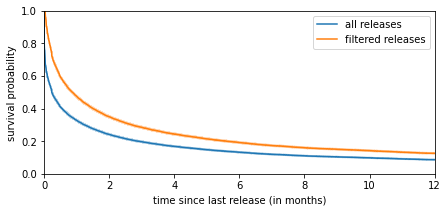

In [25]:
fig, ax = matplotlib.pyplot.subplots()

kmf = lifelines.KaplanMeierFitter()
_ = data
kmf.fit(_.duration / pd.to_timedelta('30 days'), ~_.updated.isnull(), label='all releases')
kmf.plot(legend=True, color=PALETTE[0], ax=ax)

# Excluding releases made within 24 hours: 
_ = data[lambda d: d.duration >= pd.to_timedelta('1 day')]
kmf.fit(_.duration / pd.to_timedelta('30 days'), ~_.updated.isnull(), label='filtered releases')
kmf.plot(legend=True, color=PALETTE[1], ax=ax)

ax.set(
    xlabel='time since last release (in months)', 
    xlim=(0, 12),
    ylabel='survival probability',
    ylim=(0, 1),
)

savefig(fig, 'rel_survival')

In [26]:
kmf.survival_function_at_times(range(0, 13))

0     1.000000
1     0.475087
2     0.349930
3     0.285029
4     0.243631
5     0.214076
6     0.191342
7     0.173091
8     0.159770
9     0.150324
10    0.141929
11    0.132316
12    0.125453
Name: filtered releases, dtype: float64